In [405]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

In [444]:
df = pd.read_csv('car_price.csv')
df.head(2)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650


In [445]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

cols = list(df.dtypes[df.dtypes == 'object'].index)

for col in cols:
    df[col] = df[col].str.lower().str.replace(" ", "_")

In [446]:
df.head(2)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650


In [447]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

In [448]:
df = df.fillna(0)

In [449]:
full_train, df_test = train_test_split(df, random_state=5, test_size=0.2)
df_train, df_valid = train_test_split(full_train, random_state=5, test_size=0.33)

In [450]:
y_train = np.log1p(df_train.msrp.values)
y_valid = np.log1p(df_valid.msrp.values)

del df_train['msrp']
del df_valid['msrp']

In [451]:
categorical = df.dtypes[df.dtypes == 'object'].index.to_list()
categorical

['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

In [452]:
numerical = df.dtypes[df.dtypes != 'object'].index.to_list()
numerical = [x for x in numerical if x != 'msrp']
numerical

['year',
 'engine_hp',
 'engine_cylinders',
 'number_of_doors',
 'highway_mpg',
 'city_mpg',
 'popularity']

In [453]:
df[numerical].corrwith(df.msrp)

year                0.227590
engine_hp           0.650095
engine_cylinders    0.526274
number_of_doors    -0.128627
highway_mpg        -0.160043
city_mpg           -0.157676
popularity         -0.048476
dtype: float64

In [454]:
df_train.isnull().sum()

make                 0
model                0
year                 0
engine_fuel_type     0
engine_hp            0
engine_cylinders     0
transmission_type    0
driven_wheels        0
number_of_doors      0
market_category      0
vehicle_size         0
vehicle_style        0
highway_mpg          0
city_mpg             0
popularity           0
dtype: int64

In [455]:
train_dict = df_train[numerical + categorical].to_dict(orient='records')
valid_dict = df_valid[numerical + categorical].to_dict(orient='records')

In [456]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_valid = dv.transform(valid_dict)

# Decision Tree Regressor

In [223]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [224]:
y_pred_train = dtr.predict(X_train)
y_pred_valid = dtr.predict(X_valid)

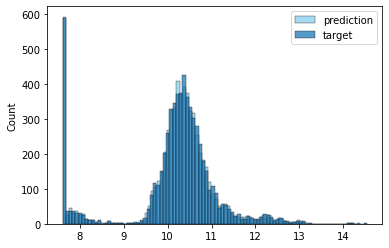

In [225]:
sns.histplot(y_pred_train, label='prediction', color = "skyblue")
sns.histplot(y_train, label='target')
plt.legend()
plt.show()

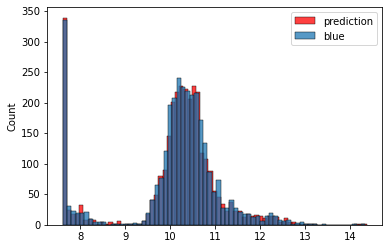

In [226]:
sns.histplot(y_pred_valid, label='prediction', color='red')
sns.histplot(y_valid, label='blue')
plt.legend()
plt.show()

In [227]:
from sklearn.metrics import mean_squared_error, r2_score 

def metrics(y_test, y_pred, X_train):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Customer adjusted r-sq
    n = y_pred.shape[0]
    k = X_train.shape[1]
    
    adjusted = 1 - (1 - r2) * (n - 1) / (n - 1 - k)
    return rmse, r2, adjusted 

In [228]:
rmse, r2, r2_adjusted = metrics(y_train, y_pred_train, X_train)
print(rmse, r2, r2_adjusted)

rmse, r2, r2_adjusted = metrics(y_valid, y_pred_valid, X_valid)
print(rmse, r2, r2_adjusted)

0.049344522352345085 0.9979702379641339 0.9975793011700038
0.1338632156296073 0.9861767292701571 0.9794351057495951


# Parameter tuning for DecisionTreeRegressor

In [112]:
for d in [1, 5, 10, 15, 20, 25, 30, None]:
    dtr = DecisionTreeRegressor(max_depth=d, random_state=5)
    dtr.fit(X_train, y_train)
    y_pred = dtr.predict(X_valid)
    rmse, r2, r2_ad = metrics(y_valid, y_pred, X_valid)
    print(f"{d}, {round(rmse, 4)}, {round(r2, 4)}, {round(r2_ad, 4)}")

1, 0.565, 0.7538, 0.6337
5, 0.2352, 0.9573, 0.9365
10, 0.1533, 0.9819, 0.973
15, 0.1336, 0.9862, 0.9795
20, 0.1365, 0.9856, 0.9786
25, 0.1319, 0.9866, 0.98
30, 0.1341, 0.9861, 0.9794
None, 0.1329, 0.9864, 0.9797


In [113]:
# from above we see: without depth we have the best `rmse`
# Now let's deal with `min_samples_leaf`
for leaf in [1, 5, 10, 20, 50, 100]:
    dtr = DecisionTreeRegressor(max_depth=None, min_samples_leaf=leaf,
                                random_state=5)
    dtr.fit(X_train, y_train)
    y_pred = dtr.predict(X_valid)
    rmse, r2, r2_ad = metrics(y_valid, y_pred, X_valid)
    print(f"{leaf}, {round(rmse, 4)}, {round(r2, 4)}, {round(r2_ad, 4)}")

1, 0.1329, 0.9864, 0.9797
5, 0.1507, 0.9825, 0.9739
10, 0.1677, 0.9783, 0.9677
20, 0.1798, 0.9751, 0.9629
50, 0.2136, 0.9648, 0.9476
100, 0.2273, 0.9602, 0.9407


In [114]:
# with `min_samples_leaf` the case is the same
# Last one is `max_features`
for f in [None, 1, 5, 10, 20, 50, 100]:
    dtr = DecisionTreeRegressor(max_depth=None, min_samples_leaf=1,
                                max_features=f, random_state=5)
    dtr.fit(X_train, y_train)
    y_pred = dtr.predict(X_valid)
    rmse, r2, r2_ad = metrics(y_valid, y_pred, X_valid)
    print(f"{f}, {round(rmse, 4)}, {round(r2, 4)}, {round(r2_ad, 4)}")

None, 0.1329, 0.9864, 0.9797
1, 0.4071, 0.8722, 0.8098
5, 0.359, 0.9006, 0.8521
10, 0.2953, 0.9328, 0.9
20, 0.2453, 0.9536, 0.931
50, 0.2177, 0.9634, 0.9456
100, 0.2091, 0.9663, 0.9498


In [115]:
# => we see that `default` params in our case are the best ones
dtr = DecisionTreeRegressor(max_depth=None, min_samples_leaf=1,
                            max_features=None, random_state=5)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(random_state=5)

In [116]:
d = [{'make': 'bmw',
 'model': '1_series',
 'year': 2012,
 'engine_fuel_type': 'premium_unleaded_(required)',
 'engine_hp': 300.0,
 'engine_cylinders': 6.0,
 'transmission_type': 'manual',
 'driven_wheels': 'rear_wheel_drive',
 'number_of_doors': 2.0,
 'market_category': 'luxury,high-performance',
 'vehicle_size': 'compact',
 'vehicle_style': 'coupe',
 'highway_mpg': 28,
 'city_mpg': 20,
 'popularity': 3916}]

In [117]:
test_data = dv.transform(d)
result = dtr.predict(test_data)[0]
np.expm1(result)
# # 'msrp': 39300

39299.99999999996

# Random Forest Regressor

In [118]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [119]:
y_pred_train = rfr.predict(X_train)
y_pred_valid = rfr.predict(X_valid)

In [120]:
rmse, r2, r2_ad = metrics(y_train, y_pred_train, X_train)
print(rmse, r2, r2_ad)

rmse, r2, r2_ad = metrics(y_valid, y_pred_valid, X_valid)
print(rmse, r2, r2_ad)

0.06178234680635385 0.9968180303832851 0.9962051757830921
0.11108434693422463 0.9904809405429569 0.985838485339451


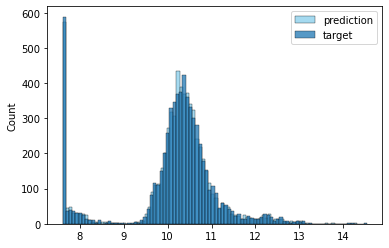

In [121]:
sns.histplot(y_pred_train, label='prediction', color = "skyblue")
sns.histplot(y_train, label='target')
plt.legend()
plt.show()

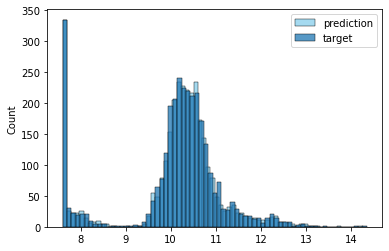

In [123]:
sns.histplot(y_pred_valid, label='prediction', color = "skyblue")
sns.histplot(y_valid, label='target')
plt.legend()
plt.show()

# Parameter tuning for Random Forest Regressor

In [161]:
all_metrics = {}

for d in [1, 15, 30, None]:
    aucs = []
    
    for i in range(10, 201, 30):
        rfr = RandomForestRegressor(n_estimators=i, random_state=5,
                                    max_depth=d)
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_valid)
        rmse, r2, r2_adj = metrics(y_valid, y_pred, X_valid)
        print(f"{d}, {i}, {rmse}")
        aucs.append([rmse, r2, r2_adj])
    
    all_metrics[d] = aucs
        

1, 10, 0.5649501920133514
1, 40, 0.5649643059599161
1, 70, 0.5649645734175948
1, 100, 0.5649613284940145
1, 130, 0.5649637182225474
1, 160, 0.5649607555497517
1, 190, 0.5649628057762309
15, 10, 0.11143024154947549
15, 40, 0.10988105418769577
15, 70, 0.10977877211035914
15, 100, 0.10915113326724188
15, 130, 0.10964511686928917
15, 160, 0.10946205844655224
15, 190, 0.10941620125328419
30, 10, 0.11256510818381896
30, 40, 0.11125210499713807
30, 70, 0.11068861931375744
30, 100, 0.11007634166796958
30, 130, 0.11050489801841715
30, 160, 0.11025310092154832
30, 190, 0.11011683278735036
None, 10, 0.11217008836921494
None, 40, 0.11127634131152653
None, 70, 0.11082167912555128
None, 100, 0.11034148232398615
None, 130, 0.11086375839675988
None, 160, 0.11058582240902026
None, 190, 0.11043502568420155


In [163]:
[x[0] for x in all_metrics[1]]

[0.5649501920133514,
 0.5649643059599161,
 0.5649645734175948,
 0.5649613284940145,
 0.5649637182225474,
 0.5649607555497517,
 0.5649628057762309]

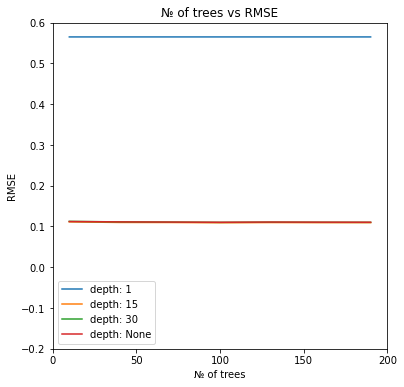

In [178]:
trees = list(range(10, 201, 30))

plt.figure(figsize=(6, 6))
plt.plot(trees, [x[0] for x in all_metrics[1]], label='depth: 1')
plt.plot(trees, [x[0] for x in all_metrics[15]], label='depth: 15')
plt.plot(trees, [x[0] for x in all_metrics[30]], label='depth: 30')
plt.plot(trees, [x[0] for x in all_metrics[None]], label='depth: None')

plt.xticks(range(0, 201, 50))

plt.ylim([-0.2, 0.6])
plt.title('№ of trees vs RMSE')
plt.xlabel('№ of trees')
plt.ylabel('RMSE')

plt.legend()
plt.show()

In [179]:
# best depth: 30
# now let's see `min_samples_leaf`
all_metrics_leaf = {}

for leaf in [1, 5]:
    metric = []
    
    for i in range(10, 201, 30):
        rfr = RandomForestRegressor(n_estimators=i, random_state=5,
                                    max_depth=30 , min_samples_leaf=leaf)
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_valid)
        rmse, r2, r2_adj = metrics(y_valid, y_pred, X_valid)
        print(f"{leaf}, {i}, {rmse}")
        metric.append([rmse, r2, r2_adj])
    
    all_metrics_leaf[leaf] = metric
        

1, 10, 0.11256510818381896
1, 40, 0.11125210499713807
1, 70, 0.11068861931375744
1, 100, 0.11007634166796958
1, 130, 0.11050489801841715
1, 160, 0.11025310092154832
1, 190, 0.11011683278735036
5, 10, 0.1379802978840595
5, 40, 0.13320947522312337
5, 70, 0.13313830154299564
5, 100, 0.13335863453885533
5, 130, 0.13382796650092385
5, 160, 0.13355306747568407
5, 190, 0.13348706298794655
10, 10, 0.15450280678632058
10, 40, 0.15150280935529087
10, 70, 0.15175475115595224
10, 100, 0.15216651377496607


KeyboardInterrupt: 

In [ ]:
trees = list(range(10, 201, 30))

plt.plot(trees, [x[0] for x in all_metrics[1]], label='leaf: 1')
plt.plot(trees, [x[0] for x in all_metrics[15]], label='leaf: 5')
plt.plot(trees, [x[0] for x in all_metrics[30]], label='leaf: 10')

plt.figure(figsize=(6, 6))
plt.xticks(range(0, 201, 50))
plt.ylim([-0.2, 0.6])
plt.title('№ of trees vs RMSE')
plt.xlabel('№ of trees')
plt.ylabel('RMSE')

plt.legend()
plt.show()

In [185]:
# best depth: 30, best. leaf: 1 
# now let's see `max_features`
all_metrics_features = {}

for f in [30, 40]:
    metric= []
    
    for i in range(10, 201, 30):
        rfr = RandomForestRegressor(n_estimators=i, random_state=5,
                                    max_depth=30, min_samples_leaf=1,
                                    max_features=f)
        rfr.fit(X_train, y_train)
        y_pred = rfr.predict(X_valid)
        rmse, r2, r2_adj = metrics(y_valid, y_pred, X_valid)
        print(f"{f}, {i}, {rmse}")
        metric.append([rmse, r2, r2_adj])
    
    all_metrics_features[f] = metric
        

30, 10, 0.20130305473477603
30, 40, 0.16808945466930458
30, 70, 0.1709627082774639
30, 100, 0.1835286281149022
30, 130, 0.18380038715046337
30, 160, 0.1815166529037011
30, 190, 0.18593344280246282
40, 10, 0.16948084176767378
40, 40, 0.1430406539833151
40, 70, 0.14384109728862365
40, 100, 0.1443641659135747
40, 130, 0.14071869373326198
40, 160, 0.1403026021416219
40, 190, 0.14181802695014742


# Checking overfitting for final model and testing

In [229]:
rfr = RandomForestRegressor(n_estimators=190, random_state=5,
                            max_depth=30, min_samples_leaf=1,
                            max_features=40)
rfr.fit(X_train, y_train)
y_pred_valid_final = rfr.predict(X_valid)

In [230]:
rmse, r2, adjusted = metrics(y_valid, y_pred_valid_final, X_valid)
print(rmse, r2, adjusted)

0.14181802695014742 0.984485021251355 0.9769183499694944


In [457]:
# before converting to dict, we need to get
# `y`like variables and remove `msrp`
y_train_full = np.log1p(full_train.msrp.values)
y_test = np.log1p(df_test.msrp.values)

del full_train['msrp']
del df_test['msrp']

In [458]:
dict_full_train = full_train.to_dict(orient='records')
dict_test = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)
X_test = dv.transform(dict_test)

In [421]:
rfr = RandomForestRegressor(n_estimators=190, random_state=5,
                            max_depth=30, min_samples_leaf=1,
                            max_features=40)

rfr.fit(X_full_train, y_train_full)
y_pred_test = rfr.predict(X_test)

In [234]:
rmse, r2, adjusted = metrics(y_test, y_pred_test, X_test)
print(rmse, r2, adjusted)

0.13328562085797369 0.9850001670199523 0.9728910454032825


In [235]:
d = [{'make': 'bmw',
 'model': '1_series',
 'year': 2012,
 'engine_fuel_type': 'premium_unleaded_(required)',
 'engine_hp': 300.0,
 'engine_cylinders': 6.0,
 'transmission_type': 'manual',
 'driven_wheels': 'rear_wheel_drive',
 'number_of_doors': 2.0,
 'market_category': 'luxury,high-performance',
 'vehicle_size': 'compact',
 'vehicle_style': 'coupe',
 'highway_mpg': 28,
 'city_mpg': 20,
 'popularity': 3916}]

In [236]:
data = dv.transform(d)
result = rfr.predict(data)[0]
np.expm1(result)
# 39300

39225.35817360101

# XGB Boost

In [284]:
dtrain = xgb.DMatrix(X_train, label=y_train,
                     feature_names=dv.feature_names_)

dvalid = xgb.DMatrix(X_valid, label=y_valid,
                      feature_names=dv.feature_names_)

In [285]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1
}

In [286]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10)
y_pred_xgb = model.predict(dvalid)

In [287]:
rmse, r2, adj_r2 = metrics(y_valid, y_pred_xgb, X_valid)
print(rmse, r2, adj_r2)

0.3240509485943728 0.9189944264411942 0.8794879239155893


<h3>Let's look at changes over various figures</h3>

In [296]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1
}

In [297]:
%%capture output

model = xgb.train(xgb_params, dtrain, evals=watchlist,
                  verbose_eval=10, num_boost_round=100)

In [298]:
def parse_xgb_output(ouput):
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)

    return tree, aucs_train, aucs_val

In [301]:
tree, rmse_train, rmse_valid = parse_xgb_output(output)

In [306]:
list(zip(rmse_train, rmse_valid))

[(6.78626, 6.75661),
 (0.24928, 0.2526),
 (0.12475, 0.13765),
 (0.11374, 0.12988),
 (0.10647, 0.1246),
 (0.10197, 0.1214),
 (0.09859, 0.119),
 (0.09584, 0.11774),
 (0.09195, 0.11516),
 (0.0893, 0.1134),
 (0.08768, 0.1124)]

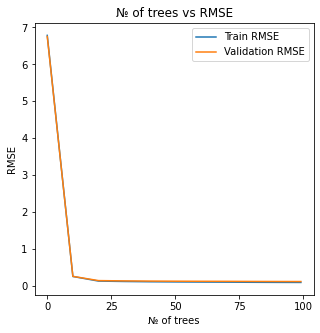

In [304]:
plt.figure(figsize=(5,5))
plt.plot(tree, rmse_train, label='Train RMSE')
plt.plot(tree, rmse_valid, label='Validation RMSE')
plt.xticks(range(0, 101, 25))

plt.title('№ of trees vs RMSE')
plt.xlabel('№ of trees')
plt.ylabel('RMSE')
plt.legend()

plt.show()

# Parameter tuning

As we'd like to find out whether we can somehow change results. Although according to above metrics we have a pretty good grasp by the model.

In [308]:
%%capture output
# at first let's adjust `eta`

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist,
                  verbose_eval=10, num_boost_round=300)

In [309]:
tree, rmse_train, rmse_valid_01 = parse_xgb_output(output)

In [314]:
print(f"max rmse: {min(rmse_valid_01)}")
print(min(zip(rmse_valid_01, tree)))

max rmse: 0.1097
(0.1097, 299)


In [323]:
%%capture output
# at first let's adjust `eta`

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist,
                  verbose_eval=10, num_boost_round=300)

In [324]:
tree, rmse_train, rmse_valid_03 = parse_xgb_output(output)

In [325]:
print(f"max rmse: {min(rmse_valid_03)}")
print(min(zip(rmse_valid_03, tree)))

max rmse: 0.1037
(0.1037, 299)


In [326]:
%%capture output
# at first let's adjust `eta`

xgb_params = {
    'eta': 0.5,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist,
                  verbose_eval=10, num_boost_round=300)

In [327]:
tree, rmse_train, rmse_valid_05 = parse_xgb_output(output)

In [330]:
print(f"max rmse: {min(rmse_valid_05)}")
print(min(zip(rmse_valid_05, tree)))

max rmse: 0.10403
(0.10403, 280)


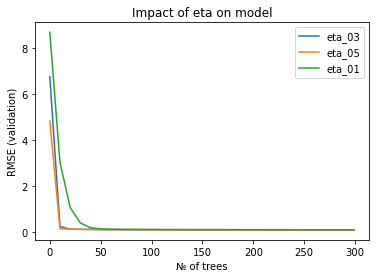

In [331]:
plt.plot(tree, rmse_valid_03, label='eta_03')
plt.plot(tree, rmse_valid_05, label='eta_05')
plt.plot(tree, rmse_valid_01, label='eta_01')
plt.xlabel('№ of trees')
plt.title('Impact of eta on model')
plt.ylabel('RMSE (validation)')
plt.xticks(range(0, 301, 50))

plt.legend()
plt.show()

In [332]:
%%capture output
# next is `max_depth`
# at first default=6

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist,
                  verbose_eval=10, num_boost_round=300)

In [333]:
tree, rmse_train, rmse_valid_6 = parse_xgb_output(output)

In [334]:
print(f"max rmse: {min(rmse_valid_6)}")
print(min(zip(rmse_valid_6, tree)))

max rmse: 0.1037
(0.1037, 299)


In [335]:
%%capture output
# max_depth=3

xgb_params = {
    'eta': 0.3,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist,
                  verbose_eval=10, num_boost_round=300)

In [336]:
tree, rmse_train, rmse_valid_3 = parse_xgb_output(output)

In [337]:
print(f"max rmse: {min(rmse_valid_3)}")
print(min(zip(rmse_valid_3, tree)))

max rmse: 0.11904
(0.11904, 299)


In [338]:
%%capture output
# max_depth=10

xgb_params = {
    'eta': 0.3,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist,
                  verbose_eval=10, num_boost_round=300)

In [339]:
tree, rmse_train, rmse_valid_10 = parse_xgb_output(output)

In [340]:
print(f"max rmse: {min(rmse_valid_10)}")
print(min(zip(rmse_valid_10, tree)))

max rmse: 0.10408
(0.10408, 220)


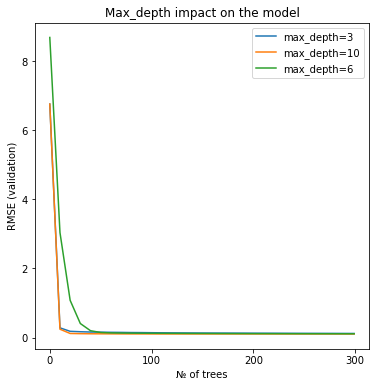

In [344]:
plt.figure(figsize=(6, 6))
plt.plot(tree, rmse_valid_3, label='max_depth=3')
plt.plot(tree, rmse_valid_10, label='max_depth=10')
plt.plot(tree, rmse_valid_01, label='max_depth=6')

plt.xlabel('№ of trees')
plt.ylabel('RMSE (validation)')
plt.title('Max_depth impact on the model')
plt.xticks(range(0, 301, 100))

plt.legend()
plt.show()

In [354]:
%%capture output
# min_child_weight=1 (default)

xgb_params = {
    'eta': 0.3,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist,
                  verbose_eval=10, num_boost_round=300)

In [355]:
tree, rmse_train, rmse_valid_1 = parse_xgb_output(output)

In [356]:
print(f"max rmse: {min(rmse_valid_1)}")
print(min(zip(rmse_valid_1, tree)))

max rmse: 0.10408
(0.10408, 220)


In [348]:
%%capture output
# min_child_weight=5

xgb_params = {
    'eta': 0.3,
    'max_depth': 10,
    'min_child_weight': 5,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist,
                  verbose_eval=10, num_boost_round=300)

In [351]:
tree, rmse_train, rmse_valid_5 = parse_xgb_output(output)

In [353]:
print(f"max rmse: {min(rmse_valid_5)}")
print(min(zip(rmse_valid_5, tree)))

max rmse: 0.10611
(0.10611, 280)


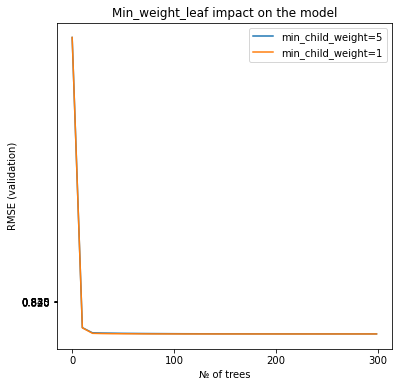

In [357]:
plt.figure(figsize=(6, 6))
plt.plot(tree, rmse_valid_5, label='min_child_weight=5')
plt.plot(tree, rmse_valid_1, label='min_child_weight=1')

plt.title('Min_weight_leaf impact on the model')
plt.xlabel('№ of trees')
plt.ylabel('RMSE (validation)')

plt.xticks(range(0, 301, 100))
plt.yticks(np.linspace(0.82, 0.84, 5))

plt.legend()
plt.show()

In [358]:
%%capture output
# 'colsample_bytree': 0.2,

xgb_params = {
    'eta': 0.3,
    'max_depth': 10,
    'min_child_weight': 1,
    'colsample_bytree': 0.2,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist,
                  verbose_eval=10, num_boost_round=300)

In [359]:
tree, rmse_train, rmse_valid_02 = parse_xgb_output(output)

In [360]:
print(f"max rmse: {min(rmse_valid_02)}")
print(min(zip(rmse_valid_02, tree)))

max rmse: 0.17548
(0.17548, 290)


In [361]:
%%capture output
# 'colsample_bytree': 0.5,

xgb_params = {
    'eta': 0.3,
    'max_depth': 10,
    'min_child_weight': 1,
    'colsample_bytree': 0.5,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist,
                  verbose_eval=10, num_boost_round=300)

In [362]:
tree, rmse_train, rmse_valid_05 = parse_xgb_output(output)

In [363]:
print(f"max rmse: {min(rmse_valid_05)}")
print(min(zip(rmse_valid_05, tree)))

max rmse: 0.12312
(0.12312, 280)


In [370]:
%%capture output
# 'colsample_bytree': 0.8,

xgb_params = {
    'eta': 0.3,
    'max_depth': 10,
    'min_child_weight': 1,
    'colsample_bytree': 0.9,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist,
                  verbose_eval=10, num_boost_round=300)

In [371]:
tree, rmse_train, rmse_valid_05 = parse_xgb_output(output)

In [372]:
print(f"max rmse: {min(rmse_valid_05)}")
print(min(zip(rmse_valid_05, tree)))

max rmse: 0.10154
(0.10154, 230)


# Using the model

In [469]:
dFullTrain = xgb.DMatrix(X_full_train, label=y_train_full,
                        feature_names=dv.feature_names_)

dTest = xgb.DMatrix(X_test, label=y_test,
                   feature_names=dv.feature_names_)

In [470]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 10,
    'min_child_weight': 1,
    'colsample_bytree': 0.9,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dFullTrain, num_boost_round=300)

In [499]:
d = [{'make': 'bmw',
 'model': '1_series',
 'year': 2012,
 'engine_fuel_type': 'premium_unleaded_(required)',
 'engine_hp': 300.0,
 'engine_cylinders': 6.0,
 'transmission_type': 'manual',
 'driven_wheels': 'rear_wheel_drive',
 'number_of_doors': 2.0,
 'market_category': 'luxury,high-performance',
 'vehicle_size': 'compact',
 'vehicle_style': 'coupe',
 'highway_mpg': 28,
 'city_mpg': 20,
 'popularity': 3916}]

data = dv.transform(d)
y_data = np.array([np.log1p(39300)])

d_matrix = xgb.DMatrix(data, label=y_data, feature_names=dv.feature_names_)

In [504]:
result = model.predict(d_matrix)[0]
np.expm1(result)
# 39300

39302.473